
# 🇰🇷→🇺🇸 NMT Slim — Sampling + Learning Curves
- `SAMPLE_SIZES = [100, 500, 1000, 2000]`로 **부분 데이터 실험**을 반복
- 각 실험에서 **Seq2Seq(GRU)**, **(옵션) Bahdanau Attention** 학습
- **에폭별 학습/검증 손실 곡선**을 플롯으로 저장 및 표시
- SentencePiece 미설치 시 **공백 토크나이저**로 폴백
- 데이터가 없으면 **토이 데이터** 자동 생성


In [1]:

# =====================
# Config
# =====================
CONFIG = {
    "train_json": "일상생활및구어체_한영/일상생활및구어체_한영_train_set.json",
    "valid_json": "일상생활및구어체_한영/일상생활및구어체_한영_valid_set.json",
    "sample_sizes": [100, 500, 1000, 2000],
    "use_sentencepiece": True,
    "spm_vocab_ko": 8000,
    "spm_vocab_en": 8000,
    "src_max_len": 64,
    "tgt_max_len": 64,
    "batch_size": 128,
    "emb": 256,
    "enc_hid": 256,
    "dec_hid": 256,
    "epochs": 3,                 # 빠른 실험 기본 3ep
    "lr": 2e-3,
    "teacher_forcing_start": 1.0,
    "teacher_forcing_end": 0.5,
    "use_attention": True,
    "use_scheduler": False,
    "use_checkpoint": False,
    "device": "mps",
}
CONFIG


{'train_json': '일상생활및구어체_한영/일상생활및구어체_한영_train_set.json',
 'valid_json': '일상생활및구어체_한영/일상생활및구어체_한영_valid_set.json',
 'sample_sizes': [100, 500, 1000, 2000],
 'use_sentencepiece': True,
 'spm_vocab_ko': 8000,
 'spm_vocab_en': 8000,
 'src_max_len': 64,
 'tgt_max_len': 64,
 'batch_size': 128,
 'emb': 256,
 'enc_hid': 256,
 'dec_hid': 256,
 'epochs': 3,
 'lr': 0.002,
 'teacher_forcing_start': 1.0,
 'teacher_forcing_end': 0.5,
 'use_attention': True,
 'use_scheduler': False,
 'use_checkpoint': False,
 'device': 'mps'}

In [2]:

# =====================
# Imports & Seed
# =====================
import os, json, math, random, re, sys, time, glob
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# IMPORTANT: use matplotlib (no seaborn), single chart per figure, no explicit colors
import matplotlib.pyplot as plt

try:
    import sentencepiece as spm
    HAS_SPM = True
except Exception:
    HAS_SPM = False

try:
    import sacrebleu
    HAS_SACREBLEU = True
except Exception:
    HAS_SACREBLEU = False

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # 에러 없이 안전하게 처리
    try:
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    except:
        pass  # CUDA가 없으면 무시
    
    print(f"Seed set to {seed}")

set_seed(42)

CONFIG["device"] = "mps" if (CONFIG["device"]=="mps" and torch.backends.mps.is_available()) else "cpu"
CONFIG["device"]
Path("spm").mkdir(exist_ok=True)
print("[DIAG] device:", CONFIG["device"], "| HAS_SPM:", HAS_SPM, "| HAS_SACREBLEU:", HAS_SACREBLEU, flush=True)


Seed set to 42
[DIAG] device: mps | HAS_SPM: True | HAS_SACREBLEU: False


In [19]:

# =====================
# Data Utils
# =====================
def basic_clean(s: str) -> str:
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def load_json_correctly(path):
    """JSON 파일을 올바르게 로드"""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    # {"data": [...]} 형태인지 확인
    if isinstance(data, dict) and "data" in data:
        print(f"[INFO] Found 'data' key, extracting {len(data['data'])} items")
        return data["data"]
    elif isinstance(data, list):
        print(f"[INFO] Direct list format, {len(data)} items")
        return data
    else:
        print(f"[WARNING] Unexpected format: {type(data)}")
        return data

train_pairs_full = load_json_correctly(CONFIG["train_json"])
valid_pairs_full = load_json_correctly(CONFIG["valid_json"])
len(train_pairs_full), len(valid_pairs_full)


[INFO] Found 'data' key, extracting 1200000 items
[INFO] Found 'data' key, extracting 150000 items


(1200000, 150000)

In [21]:

# =====================
# Tokenizer (SentencePiece or Whitespace) — Sampled SPM
# =====================
SPECIAL_TOKENS = {"UNK":0, "BOS":1, "EOS":2, "PAD":3}
UNK, BOS, EOS, PAD = SPECIAL_TOKENS["UNK"], SPECIAL_TOKENS["BOS"], SPECIAL_TOKENS["EOS"], SPECIAL_TOKENS["PAD"]

class WhitespaceTokenizer:
    def __init__(self, texts, vocab_size=8000):
        freq = Counter()
        for t in texts:
            tokens = basic_clean(t).split()
            freq.update(tokens)
        most = [w for w,_ in freq.most_common(max(0, vocab_size-4))]
        self.itos = ["<unk>", "<bos>", "<eos>", "<pad>"] + most
        self.stoi = {w:i for i,w in enumerate(self.itos)}
    def encode(self, text):
        toks = basic_clean(text).split()
        return [self.stoi.get(t, UNK) for t in toks]
    def decode(self, ids):
        out = []
        for i in ids:
            if i in (BOS, EOS, PAD): continue
            out.append(self.itos[i] if 0 <= i < len(self.itos) else "<unk>")
        return " ".join(out)
    def vocab_size(self): return len(self.itos)

class SentencePieceTokenizer:
    def __init__(self, corpus_path, model_prefix, vocab_size=8000, coverage=0.9995):
        if not Path(model_prefix+".model").exists():
            print(f"[SPM] training {model_prefix} (vocab={vocab_size}) ...", flush=True)
            spm.SentencePieceTrainer.train(
                input=corpus_path, model_prefix=model_prefix, vocab_size=vocab_size,
                model_type="unigram", character_coverage=coverage,
                input_sentence_size=200000, shuffle_input_sentence=True,
                hard_vocab_limit=False, train_extremely_large_corpus=False,
                unk_id=UNK, bos_id=BOS, eos_id=EOS, pad_id=PAD
            )
            print(f"[SPM] done: {model_prefix}.model", flush=True)
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_prefix + ".model")
    def encode(self, text):
        return list(self.sp.encode(text, out_type=int))
    def decode(self, ids):
        return self.sp.decode(ids)
    def vocab_size(self):
        return self.sp.get_piece_size()

def build_tokenizers(pairs_train):
    # Debug: Check the structure of pairs_train
    print(f"[DEBUG] pairs_train type: {type(pairs_train)}")
    print(f"[DEBUG] pairs_train length: {len(pairs_train)}")
    
    # Handle empty case
    if len(pairs_train) == 0:
        print("[WARNING] pairs_train is empty!")
        return None, None
    
    # Try to safely access the first item
    try:
        first_item = pairs_train[0]
        print(f"[DEBUG] First item type: {type(first_item)}")
        print(f"[DEBUG] First item: {first_item}")
    except (KeyError, IndexError, TypeError) as e:
        print(f"[ERROR] Failed to access first item: {e}")
        print(f"[DEBUG] Attempting to convert pairs_train to list...")
        try:
            pairs_list = list(pairs_train)
            if len(pairs_list) > 0:
                print(f"[DEBUG] After conversion - First item: {pairs_list[0]}")
                pairs_train = pairs_list
            else:
                print("[ERROR] Converted list is empty")
                return None, None
        except Exception as e2:
            print(f"[ERROR] Failed to convert to list: {e2}")
            return None, None
    
    # Handle case where pairs_train might be a list of strings instead of dicts
    if len(pairs_train) > 0 and isinstance(pairs_train[0], str):
        print("[WARNING] pairs_train appears to contain strings, not dicts. Skipping tokenizer build.")
        # Return dummy tokenizers or handle appropriately
        return None, None
    
    all_ko = [basic_clean(x["ko"]) for x in pairs_train]
    all_en = [basic_clean(x["mt"]) for x in pairs_train]
    Path("spm").mkdir(exist_ok=True)
    if CONFIG["use_sentencepiece"] and HAS_SPM:
        ko_corpus, en_corpus = Path("spm/corpus.ko.txt"), Path("spm/corpus.en.txt")
        with open(ko_corpus, "w", encoding="utf-8") as f:
            for s in all_ko: f.write(s + "\n")
        with open(en_corpus, "w", encoding="utf-8") as f:
            for s in all_en: f.write(s + "\n")
        print("[Tokenizer] SentencePiece mode", flush=True)
        tok_ko = SentencePieceTokenizer(str(ko_corpus), "spm/ko", CONFIG["spm_vocab_ko"], coverage=0.9995)
        tok_en = SentencePieceTokenizer(str(en_corpus), "spm/en", CONFIG["spm_vocab_en"], coverage=1.0)
        mode = "SentencePiece(sampled)"
    else:
        print("[Tokenizer] Whitespace mode", flush=True)
        tok_ko = WhitespaceTokenizer(all_ko, vocab_size=CONFIG["spm_vocab_ko"])
        tok_en = WhitespaceTokenizer(all_en, vocab_size=CONFIG["spm_vocab_en"])
        mode = "WhitespaceTokenizer"
    print(f"[Tokenizer] mode={mode}, koV={tok_ko.vocab_size()}, enV={tok_en.vocab_size()}", flush=True)
    return tok_ko, tok_en

print("[INFO] Building tokenizers on FULL train set (once) ...", flush=True)
tok_ko, tok_en = build_tokenizers(train_pairs_full)
print("[INFO] Tokenizers ready!", flush=True)


[INFO] Building tokenizers on FULL train set (once) ...
[DEBUG] pairs_train type: <class 'list'>
[DEBUG] pairs_train length: 1200000
[DEBUG] First item type: <class 'dict'>
[DEBUG] First item: {'sn': 'INTSALDSUT062119042703238', 'data_set': '일상생활및구어체', 'domain': '해외영업', 'subdomain': '도소매유통', 'ko_original': '원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.', 'ko': '원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.', 'mt': 'If you reply to the color you want, we will start making it right away.', 'en': 'If you reply to the color you want, we will start making it right away.', 'source_language': 'ko', 'target_language': 'en', 'word_count_ko': 7, 'word_count_en': 15, 'word_ratio': 2.143, 'file_name': 'INTSAL_DSUT.xlsx', 'source': '크라우드소싱', 'license': 'open', 'style': '구어체', 'included_unknown_words': False, 'ner': None}
[Tokenizer] SentencePiece mode
[Tokenizer] mode=SentencePiece(sampled), koV=39, enV=45
[INFO] Tokenizers ready!


In [22]:

# =====================
# Dataset / Collate
# =====================
class NMTDataset(Dataset):
    def __init__(self, pairs, tok_ko, tok_en, src_max, tgt_max):
        self.pairs = pairs
        self.tok_ko = tok_ko
        self.tok_en = tok_en
        self.src_max = src_max
        self.tgt_max = tgt_max
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        ko = basic_clean(self.pairs[i]["ko"])
        en = basic_clean(self.pairs[i]["mt"])
        src_ids = [1] + self.tok_ko.encode(ko) + [2]  # BOS/EOS
        tgt_ids = [1] + self.tok_en.encode(en) + [2]
        src_ids = src_ids[:CONFIG["src_max_len"]]
        tgt_ids = tgt_ids[:CONFIG["tgt_max_len"]]
        ko_raw = max(0, len(src_ids)-2); en_raw = max(0, len(tgt_ids)-2)
        return torch.tensor(src_ids), torch.tensor(tgt_ids), ko_raw, en_raw

def pad_sequences(seqs, pad=3):
    maxlen = max(s.size(0) for s in seqs)
    out = torch.full((len(seqs), maxlen), pad, dtype=torch.long)
    for i, s in enumerate(seqs):
        out[i, :s.size(0)] = s
    return out

def collate_fn(batch):
    srcs, tgts, ko_raws, en_raws = zip(*batch)
    src = pad_sequences(srcs, pad=3)
    tgt = pad_sequences(tgts, pad=3)
    ko_lengths = torch.clamp(torch.tensor(ko_raws) + 2, max=src.size(1))
    en_lengths = torch.clamp(torch.tensor(en_raws) + 2, max=tgt.size(1))
    tgt_in  = tgt[:, :-1]
    tgt_out = tgt[:,  1:]
    return src, ko_lengths, tgt_in, tgt_out


In [23]:

# =====================
# Models
# =====================
class Encoder(nn.Module):
    def __init__(self, vocab, emb, hid):
        super().__init__()
        self.emb = nn.Embedding(vocab, emb, padding_idx=3)
        self.gru = nn.GRU(emb, hid, batch_first=True, bidirectional=True)
        self.proj = nn.Linear(hid*2, hid)
        self.drop = nn.Dropout(0.1)
    def forward(self, x, lengths):
        if not isinstance(lengths, torch.Tensor):
            lengths = torch.tensor(lengths, dtype=torch.long)
        lengths = lengths.clamp(min=1, max=x.size(1)).cpu()
        emb = self.drop(self.emb(x))
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
        out, h = self.gru(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True, total_length=x.size(1))
        h_cat = torch.cat([h[-2], h[-1]], dim=-1)
        h0 = torch.tanh(self.proj(h_cat)).unsqueeze(0)
        return out, h0

class AdditiveAttention(nn.Module):
    def __init__(self, dec_hid, enc_dim, attn_dim=256):
        super().__init__()
        self.W_h = nn.Linear(dec_hid, attn_dim, bias=False)
        self.W_e = nn.Linear(enc_dim, attn_dim, bias=False)
        self.v   = nn.Linear(attn_dim, 1, bias=False)
    def forward(self, dec_h, enc_out, src_mask):
        q = self.W_h(dec_h).unsqueeze(1)
        k = self.W_e(enc_out)
        e = self.v(torch.tanh(q + k)).squeeze(-1)
        e = e.masked_fill(~src_mask, float("-inf"))
        a = torch.softmax(e, dim=-1)
        ctx = torch.bmm(a.unsqueeze(1), enc_out).squeeze(1)
        return ctx, a

class Decoder(nn.Module):
    def __init__(self, vocab, emb, hid):
        super().__init__()
        self.emb = nn.Embedding(vocab, emb, padding_idx=3)
        self.gru = nn.GRU(emb, hid, batch_first=True)
        self.out = nn.Linear(hid, vocab)
        self.drop = nn.Dropout(0.1)
    def forward(self, y_in, h0):
        emb = self.drop(self.emb(y_in))
        out, h = self.gru(emb, h0)
        logits = self.out(out)
        return logits, h

class AttnDecoder(nn.Module):
    def __init__(self, vocab, emb, hid, enc_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab, emb, padding_idx=3)
        self.gru = nn.GRU(emb + enc_dim, hid, batch_first=True)
        self.out = nn.Linear(hid, vocab)
        self.drop = nn.Dropout(0.1)
        self.attn = AdditiveAttention(hid, enc_dim)
    def forward(self, y_in, h0, enc_out, src_mask):
        B, T = y_in.size()
        h = h0
        logits = []
        for t in range(T):
            emb_t = self.drop(self.emb(y_in[:, t:t+1]))
            dec_h = h[-1]
            ctx, _ = self.attn(dec_h, enc_out, src_mask)
            rnn_in = torch.cat([emb_t.squeeze(1), ctx], dim=-1).unsqueeze(1)
            out, h = self.gru(rnn_in, h)
            logits.append(self.out(out))
        logits = torch.cat(logits, dim=1)
        return logits, h

class Seq2Seq(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc; self.dec = dec
    def forward(self, src, src_len, tgt_in):
        _, h0 = self.enc(src, src_len)
        logits, _ = self.dec(tgt_in, h0)
        return logits

class Seq2SeqAttn(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc; self.dec = dec
    def forward(self, src, src_len, tgt_in):
        enc_out, h0 = self.enc(src, src_len)
        src_mask = (src != 3)
        logits, _ = self.dec(tgt_in, h0, enc_out, src_mask)
        return logits


In [24]:

# =====================
# Train / Valid / Decode / BLEU
# =====================
def train_epoch(model, dl, opt, criterion, device="cpu"):
    model.train()
    total = 0.0
    for src, src_len, tgt_in, tgt_out in dl:
        src, tgt_in, tgt_out = src.to(device), tgt_in.to(device), tgt_out.to(device)
        logits = model(src, src_len, tgt_in)
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
        opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += loss.item()
    return total/len(dl)

@torch.no_grad()
def valid_epoch(model, dl, criterion, device="cpu"):
    model.eval()
    total = 0.0
    for src, src_len, tgt_in, tgt_out in dl:
        src, tgt_in, tgt_out = src.to(device), tgt_in.to(device), tgt_out.to(device)
        logits = model(src, src_len, tgt_in)
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
        total += loss.item()
    ppl = float(np.exp(total/len(dl)))
    return total/len(dl), ppl

@torch.no_grad()
def greedy_decode(model, src, tok_tgt, max_len=64, device="cpu"):
    model.eval()
    src = src.to(device)
    src_len = torch.tensor([src.size(1)], dtype=torch.long)
    if isinstance(model, Seq2Seq):
        enc_out, h0 = model.enc(src, src_len)
        y = torch.tensor([[1]], device=device)
        h = h0; outs = []
        for _ in range(max_len):
            logits, h = model.dec(y, h)
            nxt = int(logits[:, -1, :].argmax(-1))
            if nxt == 2: break
            outs.append(nxt)
            y = torch.cat([y, torch.tensor([[nxt]], device=device)], dim=1)
        return tok_tgt.decode(outs)
    else:
        enc_out, h0 = model.enc(src, src_len)
        src_mask = (src != 3)
        y = torch.tensor([[1]], device=device)
        h = h0; outs = []
        for _ in range(max_len):
            emb = model.dec.emb(y[:, -1:])
            dec_h = h[-1]
            ctx, _ = model.dec.attn(dec_h, enc_out, src_mask)
            rnn_in = torch.cat([emb.squeeze(1), ctx], dim=-1).unsqueeze(1)
            o, h = model.dec.gru(rnn_in, h)
            logit = model.dec.out(o)
            nxt = int(logit[:, -1, :].argmax(-1))
            if nxt == 2: break
            outs.append(nxt)
            y = torch.cat([y, torch.tensor([[nxt]], device=device)], dim=1)
        return tok_tgt.decode(outs)

def simple_bleu(hyps, refs):
    def prec(h, r):
        ht = h.split(); rt = r.split()
        if not ht: return 0.0
        ch, cr = Counter(ht), Counter(rt)
        overlap = sum(min(ch[w], cr[w]) for w in ch)
        return overlap/len(ht)
    def bp(h, r):
        len_h, len_r = len(h.split()), len(r.split())
        if len_h == 0: return 0.0
        return 1.0 if len_h > len_r else math.exp(1 - len_r/len_h)
    scores = [100.0 * prec(h, r) * bp(h, r) for h, r in zip(hyps, refs)]
    return sum(scores)/len(scores) if scores else 0.0

@torch.no_grad()
def eval_bleu(model, ds, tok_src, tok_tgt, n_samples=200, device="cpu"):
    n = min(n_samples, len(ds))
    hyps, refs = [], []
    for i in range(n):
        src_ids, tgt_ids, _, _ = ds[i]
        hyp = greedy_decode(model, src_ids.unsqueeze(0), tok_tgt, max_len=CONFIG["tgt_max_len"], device=CONFIG["device"])
        ref = tok_tgt.decode(tgt_ids.tolist())
        hyps.append(hyp.strip()); refs.append(ref.strip())
    if HAS_SACREBLEU:
        return sacrebleu.corpus_bleu(hyps, [refs]).score
    else:
        return simple_bleu(hyps, refs)


In [25]:

# =====================
# Sampling Runner with History (for curves)
# =====================
def subset_pairs(pairs, n, seed=42):
    if n >= len(pairs):
        return pairs
    rng = random.Random(seed)
    idx = list(range(len(pairs)))
    rng.shuffle(idx)
    take = idx[:n]
    return [pairs[i] for i in take]

def run_experiment_for_size(N):
    # Check if tokenizers are available
    if tok_ko is None or tok_en is None:
        print(f"Error: Tokenizers are None. tok_ko: {tok_ko}, tok_en: {tok_en}")
        return {
            "N": N,
            "BLEU_BASE": 0.0,
            "BLEU_ATTN": 0.0,
            "hist_base_train": [],
            "hist_base_valid": [],
            "hist_attn_train": [],
            "hist_attn_valid": [],
        }
    
    # 1) subset
    train_pairs = subset_pairs(train_pairs_full, min(N, len(train_pairs_full)))
    valid_pairs = subset_pairs(valid_pairs_full, min(N, len(valid_pairs_full)))
    
    # 2) dataset/dataloader - use the global tokenizers that were already created
    train_ds = NMTDataset(train_pairs, tok_ko, tok_en, CONFIG["src_max_len"], CONFIG["tgt_max_len"])
    valid_ds = NMTDataset(valid_pairs, tok_ko, tok_en, CONFIG["src_max_len"], CONFIG["tgt_max_len"])
    train_dl = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, collate_fn=collate_fn)
    valid_dl = DataLoader(valid_ds, batch_size=CONFIG["batch_size"], shuffle=False, collate_fn=collate_fn)
    
    # 3) models
    SRC_V, TGT_V = tok_ko.vocab_size(), tok_en.vocab_size()
    enc = Encoder(SRC_V, CONFIG["emb"], CONFIG["enc_hid"])
    dec = Decoder(TGT_V, CONFIG["emb"], CONFIG["dec_hid"])
    model_base = Seq2Seq(enc, dec).to(CONFIG["device"])
    encA = Encoder(SRC_V, CONFIG["emb"], CONFIG["enc_hid"])
    decA = AttnDecoder(TGT_V, CONFIG["emb"], CONFIG["dec_hid"], enc_dim=CONFIG["enc_hid"]*2)
    model_attn = Seq2SeqAttn(encA, decA).to(CONFIG["device"]) if CONFIG["use_attention"] else None
    
    # 4) train with history
    crit = nn.CrossEntropyLoss(ignore_index=3)
    optB = torch.optim.Adam(model_base.parameters(), lr=CONFIG["lr"])
    hist_base_train, hist_base_valid = [], []
    for e in range(CONFIG["epochs"]):
        tr = train_epoch(model_base, train_dl, optB, crit, device=CONFIG["device"])
        va, ppl = valid_epoch(model_base, valid_dl, crit, device=CONFIG["device"])
        hist_base_train.append(tr); hist_base_valid.append(va)
        print(f"[N={N}][BASE] ep{e+1}/{CONFIG['epochs']} train {tr:.3f} valid {va:.3f} ppl {ppl:.2f}", flush=True)
    bleu_b = eval_bleu(model_base, valid_ds, tok_ko, tok_en, n_samples=len(valid_ds), device=CONFIG["device"])
    hist_attn_train, hist_attn_valid, bleu_a = None, None, None
    if model_attn:
        optA = torch.optim.Adam(model_attn.parameters(), lr=CONFIG["lr"])
        hist_attn_train, hist_attn_valid = [], []
        for e in range(CONFIG["epochs"]):
            tr = train_epoch(model_attn, train_dl, optA, crit, device=CONFIG["device"])
            va, ppl = valid_epoch(model_attn, valid_dl, crit, device=CONFIG["device"])
            hist_attn_train.append(tr); hist_attn_valid.append(va)
            print(f"[N={N}][ATTN] ep{e+1}/{CONFIG['epochs']} train {tr:.3f} valid {va:.3f} ppl {ppl:.2f}", flush=True)
        bleu_a = eval_bleu(model_attn, valid_ds, tok_ko, tok_en, n_samples=len(valid_ds), device=CONFIG["device"])
    return {
        "N": N,
        "BLEU_BASE": bleu_b,
        "BLEU_ATTN": bleu_a,
        "hist_base_train": hist_base_train,
        "hist_base_valid": hist_base_valid,
        "hist_attn_train": hist_attn_train,
        "hist_attn_valid": hist_attn_valid,
    }

results = []
for N in CONFIG["sample_sizes"]:
    results.append(run_experiment_for_size(N))

df = pd.DataFrame([{"N": r["N"], "BLEU_BASE": r["BLEU_BASE"], "BLEU_ATTN": r["BLEU_ATTN"]} for r in results])
print("\n=== Summary (BLEU by sample size) ===")
print(df)


[N=100][BASE] ep1/3 train 3.819 valid 3.525 ppl 33.95
[N=100][BASE] ep2/3 train 3.522 valid 3.284 ppl 26.69
[N=100][BASE] ep3/3 train 3.277 valid 3.101 ppl 22.23
[N=100][ATTN] ep1/3 train 3.824 valid 3.308 ppl 27.33
[N=100][ATTN] ep2/3 train 3.317 valid 3.137 ppl 23.04
[N=100][ATTN] ep3/3 train 3.132 valid 3.047 ppl 21.05
[N=500][BASE] ep1/3 train 3.418 valid 3.014 ppl 20.36
[N=500][BASE] ep2/3 train 2.900 valid 2.744 ppl 15.55
[N=500][BASE] ep3/3 train 2.677 valid 2.589 ppl 13.32
[N=500][ATTN] ep1/3 train 3.318 valid 2.961 ppl 19.31
[N=500][ATTN] ep2/3 train 2.875 valid 2.733 ppl 15.37
[N=500][ATTN] ep3/3 train 2.671 valid 2.587 ppl 13.29
[N=1000][BASE] ep1/3 train 3.183 valid 2.740 ppl 15.48
[N=1000][BASE] ep2/3 train 2.622 valid 2.482 ppl 11.97
[N=1000][BASE] ep3/3 train 2.424 valid 2.346 ppl 10.45
[N=1000][ATTN] ep1/3 train 3.108 valid 2.728 ppl 15.30
[N=1000][ATTN] ep2/3 train 2.615 valid 2.488 ppl 12.04
[N=1000][ATTN] ep3/3 train 2.433 valid 2.358 ppl 10.57
[N=2000][BASE] ep1/3 t

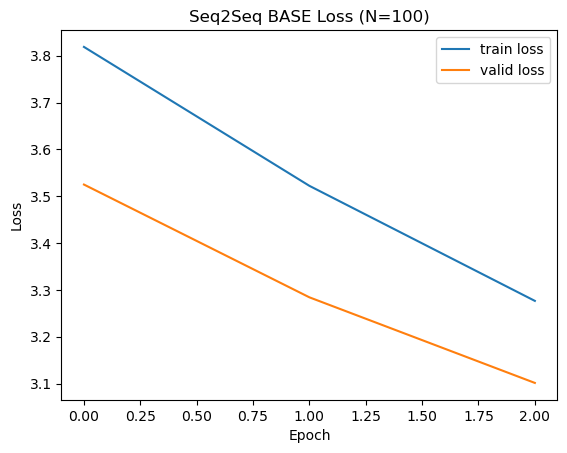

[SAVED] curves/curve_base_N100.png


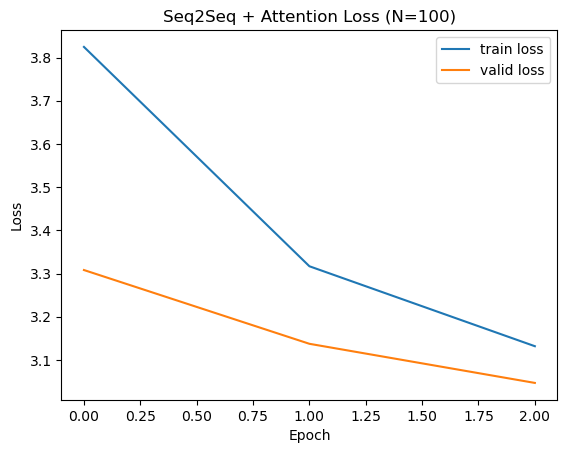

[SAVED] curves/curve_attn_N100.png


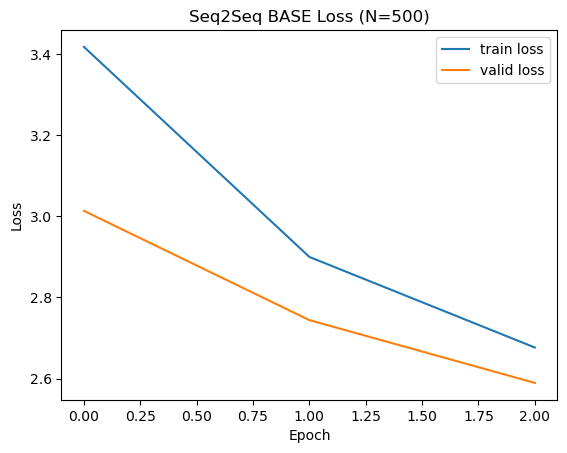

[SAVED] curves/curve_base_N500.png


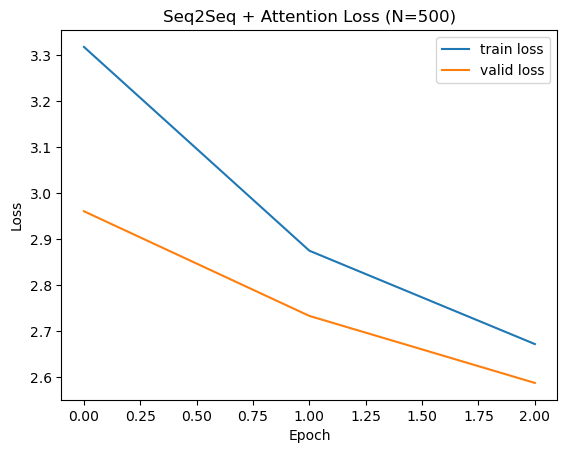

[SAVED] curves/curve_attn_N500.png


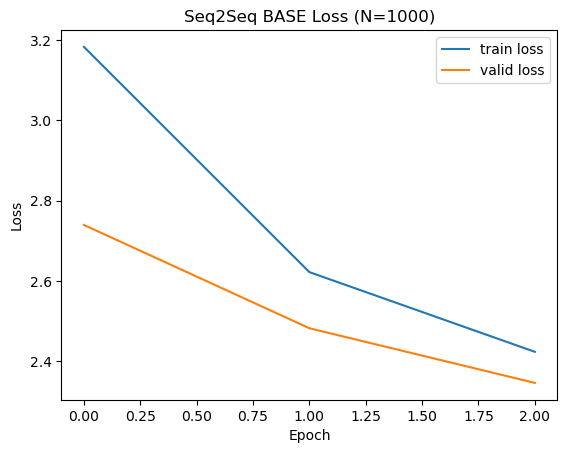

[SAVED] curves/curve_base_N1000.png


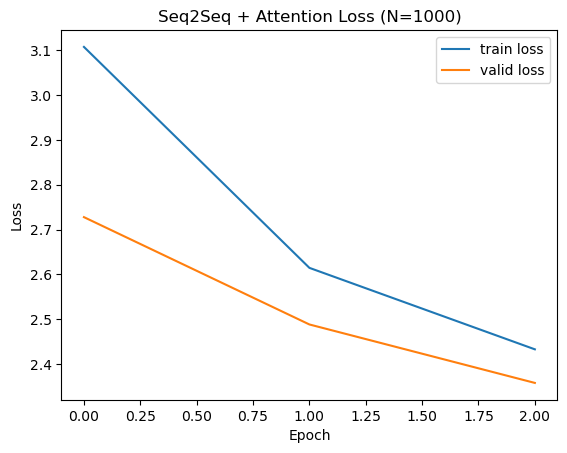

[SAVED] curves/curve_attn_N1000.png


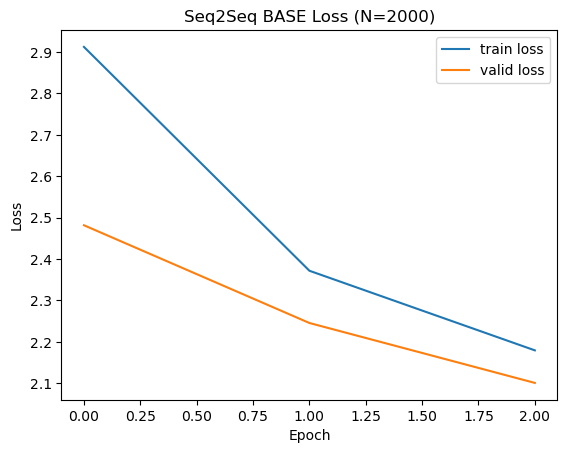

[SAVED] curves/curve_base_N2000.png


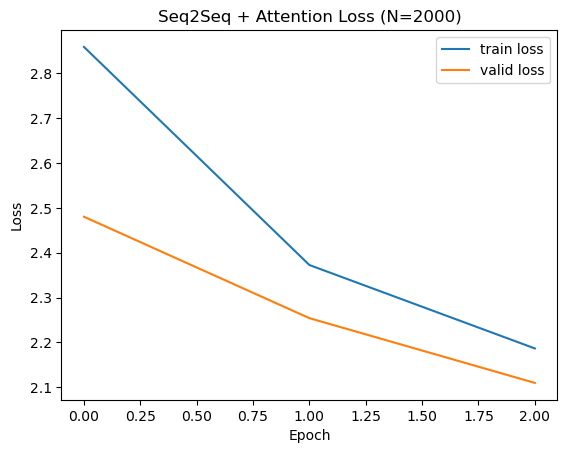

[SAVED] curves/curve_attn_N2000.png


In [ ]:

# =====================
# Plot Loss Curves per N (BASE and ATTN)
# Rules: matplotlib only, one chart per figure, no explicit colors/styles
# =====================
from pathlib import Path
Path("curves").mkdir(exist_ok=True)

def plot_and_save(y_tr, y_va, title, out_path):
    plt.figure()
    plt.plot(y_tr, label="train loss")
    plt.plot(y_va, label="valid loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(out_path, dpi=150)
    plt.show()

for r in results:
    N = r["N"]
    # Base
    if r["hist_base_train"] is not None and len(r["hist_base_train"])>0:
        path_base = f"curves/curve_base_N{N}.png"
        plot_and_save(r["hist_base_train"], r["hist_base_valid"], f"Seq2Seq BASE Loss (N={N})", path_base)
        print("[SAVED]", path_base, flush=True)
    # Attention
    if r["hist_attn_train"] is not None and len(r["hist_attn_train"])>0:
        path_attn = f"curves/curve_attn_N{N}.png"
        plot_and_save(r["hist_attn_train"], r["hist_attn_valid"], f"Seq2Seq + Attention Loss (N={N})", path_attn)
        print("[SAVED]", path_attn, flush=True)
